## Script to load in a processed seurat object and run pySCENIC

To get your processed Seurat object into adata format you can use conversion functions, such as:
```r

#load custom functions
source("./customFunctions.R")

#load in processed R data and subset on OCs
seu.obj <- readRDS(file = "../output/s3/macOC_QCfiltered_2500_res0.6_dims40_dist0.25_neigh40_S3.rds")

Idents(seu.obj) <- "clusterID_sub"
seu.obj <- RenameIdents(seu.obj, c("0" = "TAM_ACT", "1" = "TAM_INT", 
                                   "2" = "LA-TAM_SPP2_hi", "3" = "LA-TAM_C1QC_hi",
                                   "4" = "CD4-_TIM","5" = "Cycling_OC",
                                   "6" = "Mature_OC", "7" = "ANGIO_TAM", 
                                   "8" = "Cycling_OC", "9" = "CD320_OC", 
                                   "10" = "IFN-TAM", "11" = "CD4+_TIM")
                       )

seu.obj$majorID <- Idents(seu.obj)

seu.obj <- subset(seu.obj,
                  subset = 
                  majorID ==  "Mature_OC" | majorID ==  "CD320_OC" | majorID == "Cycling_OC") 


cnts <- seu.obj@assays$RNA@counts
cnts <- orthogene::convert_orthologs(gene_df = cnts,
                                        gene_input = "rownames", 
                                        gene_output = "rownames", 
                                        input_species = "dog",
                                        output_species = "human",
                                        non121_strategy = "drop_both_species") 
rownames(cnts) <- unname(rownames(cnts))

seu.obj <- CreateSeuratObject(cnts, project = "humanConvert", assay = "RNA",
                                  min.cells = 0, min.features = 0, names.field = 1,
                                  names.delim = "_", meta.data = seu.obj@meta.data)


seu.obj <- NormalizeData(seu.obj)


SaveH5Seurat(seu.obj, filename = "../output/s3/oc_hu.h5Seurat")
Convert("../output/s3/oc_hu.h5Seurat", dest = "h5ad")
```

In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import loompy as lp
from matplotlib.pyplot import rc_context
from MulticoreTSNE import MulticoreTSNE as TSNE
from pyscenic.export import export2loom, add_scenic_metadata

import seaborn as sns
import matplotlib.pyplot as plt
import scipy 

import glob

import json
import zlib
import base64

In [2]:
FIGURES_FOLDERNAME="../output/scenic/"
def savesvg(fname: str, fig, folder: str=FIGURES_FOLDERNAME) -> None:
    """
    Save figure as vector-based SVG image format.
    """
    fig.tight_layout()
    fig.savefig(os.path.join(folder, fname), format='svg')

In [3]:
#load in the data
adata = sc.read_h5ad("../output/s3/oc_hu.h5ad")
adata

AnnData object with n_obs × n_vars = 2102 × 12928
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'percent.hbm', 'percent.ppbp', 'RNA_snn_res.0.1', 'seurat_clusters', 'int.clusID', 'pANN_0.25_0.14_157', 'DF.classifications_0.25_0.14_157', 'doublet', 'S.Score', 'G2M.Score', 'Phase', 'clusters', 'nCount_SCT', 'nFeature_SCT', 'pANN_0.25_0.005_142', 'DF.classifications_0.25_0.005_142', 'pANN_0.25_0.005_172', 'DF.classifications_0.25_0.005_172', 'pANN_0.25_0.13_168', 'DF.classifications_0.25_0.13_168', 'pANN_0.25_0.04_209', 'DF.classifications_0.25_0.04_209', 'pANN_0.25_0.005_94', 'DF.classifications_0.25_0.005_94', 'pANN_0.25_0.16_79', 'DF.classifications_0.25_0.16_79', 'pANN_0.25_0.12_96', 'DF.classifications_0.25_0.12_96', 'integrated_snn_res.0.8', 'clusterID', 'orig.ident_2', 'majorID', 'freqID', 'id', 'tumorO', 'intID', 'name', 'colz', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'clusterID_final', 'integrated_snn_res.0.6', 'clusterID_sub', 'major', 'majorID_sub', 'i

In [5]:
#convert from numeric to string
anno = adata.obs
anno['majorID'] = anno.majorID.astype(str)
adata.obs = anno

In [6]:
#convert index to gene symbol
tempAdata = adata.raw.to_adata()
tempAdata.var_names = adata.var['features']
adata.raw = tempAdata

In [30]:
# create basic row and column attributes for the loom file:
row_attrs = {
    "Gene": np.array(adata.var_names) ,
}
col_attrs = {
    "CellID": np.array(adata.obs_names) ,
    "nGene": np.array( np.sum(adata.X.transpose()>0 , axis=0)).flatten() ,
    "nUMI": np.array( np.sum(adata.X.transpose() , axis=0)).flatten() ,
}
lp.create( "../output/s3/oc_hu.loom", adata.X.transpose(), row_attrs, col_attrs)

The easiest way to run the code is to use a sbatch script, so generate a script with:

In [31]:
!echo "#!/usr/bin/env bash" > cute_pyScenic_grn.sbatch
!echo "#SBATCH --job-name=pySCENIC_grn" >> cute_pyScenic_grn.sbatch

!echo "#SBATCH --nodes=1" >> cute_pyScenic_grn.sbatch
!echo "#SBATCH --ntasks=16" >> cute_pyScenic_grn.sbatch
!echo "#SBATCH --time=00:30:00" >> cute_pyScenic_grn.sbatch

!echo "#SBATCH --partition=amilan" >> cute_pyScenic_grn.sbatch
!echo "#SBATCH --qos=normal" >> cute_pyScenic_grn.sbatch

!echo "#SBATCH --mail-type=END" >> cute_pyScenic_grn.sbatch
!echo "#SBATCH --mail-user=dyammons@colostate.edu" >> cute_pyScenic_grn.sbatch
!echo "#SBATCH --output=pySCENIC_grn-%j.log" >> cute_pyScenic_grn.sbatch

!echo "" >> cute_pyScenic_grn.sbatch

!echo "#load conda env" >> cute_pyScenic_grn.sbatch
!echo "source /curc/sw/anaconda3/latest" >> cute_pyScenic_grn.sbatch
!echo "conda activate scPy" >> cute_pyScenic_grn.sbatch

!echo "" >> cute_pyScenic_grn.sbatch

!echo "#call cmd" >> cute_pyScenic_grn.sbatch
!echo "pyscenic grn ../output/s3/oc_hu.loom \\" >> cute_pyScenic_grn.sbatch
!echo "./metaData/allTFs_hg38.txt \\" >> cute_pyScenic_grn.sbatch
!echo "-o ../output/scenic/oc_adj.csv \\" >> cute_pyScenic_grn.sbatch
!echo "--num_workers \$SLURM_NTASKS" >> cute_pyScenic_grn.sbatch

In [32]:
#submit the job
!sbatch cute_pyScenic_grn.sbatch

Submitted batch job 4294500


In [33]:
!echo "#!/usr/bin/env bash" > cute_pyScenic_ctx.sbatch
!echo "#SBATCH --job-name=pySCENIC_ctx" >> cute_pyScenic_ctx.sbatch

!echo "#SBATCH --nodes=1" >> cute_pyScenic_ctx.sbatch
!echo "#SBATCH --ntasks=10" >> cute_pyScenic_ctx.sbatch
!echo "#SBATCH --time=00:20:00" >> cute_pyScenic_ctx.sbatch

!echo "#SBATCH --partition=amilan" >> cute_pyScenic_ctx.sbatch
!echo "#SBATCH --qos=normal" >> cute_pyScenic_ctx.sbatch

!echo "#SBATCH --mail-type=END" >> cute_pyScenic_ctx.sbatch
!echo "#SBATCH --mail-user=dyammons@colostate.edu" >> cute_pyScenic_ctx.sbatch
!echo "#SBATCH --output=pySCENIC_ctx-%j.log" >> cute_pyScenic_ctx.sbatch

!echo "" >> cute_pyScenic_ctx.sbatch

!echo "#load conda env" >> cute_pyScenic_ctx.sbatch
!echo "source /curc/sw/anaconda3/latest" >> cute_pyScenic_ctx.sbatch
!echo "conda activate scPy" >> cute_pyScenic_ctx.sbatch

!echo "" >> cute_pyScenic_ctx.sbatch

!echo "pyscenic ctx ../output/scenic/oc_adj.csv \\" >> cute_pyScenic_ctx.sbatch
!echo "./metaData/hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr.feather ./metaData/hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.feather \\" >> cute_pyScenic_ctx.sbatch
!echo "--annotations_fname ./metaData/motifs-v9-nr.hgnc-m0.001-o0.0.tbl \\" >> cute_pyScenic_ctx.sbatch
!echo "--expression_mtx_fname ../output/s3/oc_hu.loom \\" >> cute_pyScenic_ctx.sbatch
!echo "--output ../output/scenic/oc_reg.csv \\" >> cute_pyScenic_ctx.sbatch
!echo "--mask_dropouts \\" >> cute_pyScenic_ctx.sbatch
!echo "--num_workers \$SLURM_NTASKS" >> cute_pyScenic_ctx.sbatch


In [34]:
#submit the job; took 8 min....
!sbatch cute_pyScenic_ctx.sbatch

Submitted batch job 4294831


In [35]:
!echo "#!/usr/bin/env bash" > cute_pyScenic_aucell.sbatch
!echo "#SBATCH --job-name=pySCENIC_auc" >> cute_pyScenic_aucell.sbatch

!echo "#SBATCH --nodes=1" >> cute_pyScenic_aucell.sbatch
!echo "#SBATCH --ntasks=4" >> cute_pyScenic_aucell.sbatch
!echo "#SBATCH --time=0:10:00" >> cute_pyScenic_aucell.sbatch

!echo "#SBATCH --partition=atesting" >> cute_pyScenic_aucell.sbatch
!echo "#SBATCH --qos=normal" >> cute_pyScenic_aucell.sbatch

!echo "#SBATCH --mail-type=END" >> cute_pyScenic_aucell.sbatch
!echo "#SBATCH --mail-user=dyammons@colostate.edu" >> cute_pyScenic_aucell.sbatch
!echo "#SBATCH --output=%x-%j.log" >> cute_pyScenic_aucell.sbatch

!echo "" >> cute_pyScenic_aucell.sbatch

!echo "#load conda env" >> cute_pyScenic_aucell.sbatch
!echo "source /curc/sw/anaconda3/latest" >> cute_pyScenic_aucell.sbatch
!echo "conda activate scPy" >> cute_pyScenic_aucell.sbatch

!echo "" >> cute_pyScenic_aucell.sbatch

!echo "pyscenic aucell \\" >> cute_pyScenic_aucell.sbatch
!echo "../output/s3/oc_hu.loom \\" >> cute_pyScenic_aucell.sbatch
!echo "../output/scenic/oc_reg.csv \\" >> cute_pyScenic_aucell.sbatch
!echo "--output ../output/scenic/oc_hu_scenic_output.loom \\" >> cute_pyScenic_aucell.sbatch
!echo "--num_workers \$SLURM_NTASKS" >> cute_pyScenic_aucell.sbatch

In [36]:
#took 2 min....
!sbatch cute_pyScenic_aucell.sbatch

Submitted batch job 4294901


In [9]:
# collect SCENIC AUCell output
lf = lp.connect("../output/scenic/oc_hu_scenic_output.loom", mode='r+', validate=False )
auc_mtx = pd.DataFrame( lf.ca.RegulonsAUC, index=lf.ca.CellID)
lf.close()

In [10]:
auc_mtx

,AHCTF1(+),AHR(+),AHRR(+),ARG2(+),ARID3A(+),ARNT(+),ATF1(+),ATF2(+),ATF3(+),ATF4(+),...,ZNF597(+),ZNF646(+),ZNF76(+),ZNF768(+),ZNF790(+),ZNF8(+),ZNF800(+),ZNF831(+),ZNF84(+),ZSCAN25(+)
AAACGCTGTGCCCACA-1_1,0.024794,0.0,0.0,0.067559,0.024277,0.019195,0.014057,0.021117,0.060663,0.178793,...,0.000000,0.000000,0.004157,0.0,0.000000,0.0,0.000000,0.000000,0.000471,0.000000
AAAGGTACAGGTTACT-1_1,0.024899,0.0,0.0,0.041906,0.046991,0.000000,0.022943,0.020985,0.042160,0.155186,...,0.000000,0.000000,0.000039,0.0,0.000000,0.0,0.004533,0.000000,0.000000,0.000000
AAAGTCCGTGACTGTT-1_1,0.026578,0.0,0.0,0.134233,0.037918,0.000000,0.017369,0.021832,0.090838,0.185442,...,0.000000,0.000000,0.003914,0.0,0.000000,0.0,0.000000,0.116615,0.000000,0.000000
AACAAAGCATCCGCGA-1_1,0.013801,0.0,0.0,0.160438,0.041535,0.000000,0.017698,0.020934,0.078794,0.187940,...,0.000000,0.017647,0.001110,0.0,0.000000,0.0,0.004036,0.087203,0.000000,0.013416
AACCATGCAGCTGTGC-1_1,0.019520,0.0,0.0,0.135228,0.035772,0.000000,0.015722,0.020051,0.073186,0.154130,...,0.000000,0.000000,0.010515,0.0,0.000000,0.0,0.000000,0.100103,0.000000,0.012900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGAGTGCAGGAGGTT-1_8,0.036732,0.0,0.0,0.037594,0.038983,0.000000,0.017901,0.018036,0.060964,0.209436,...,0.000000,0.000000,0.002512,0.0,0.000000,0.0,0.002985,0.000000,0.000000,0.000000
TTGATGGCATACACCA-1_8,0.009262,0.0,0.0,0.070544,0.030569,0.022639,0.010386,0.021205,0.049482,0.132845,...,0.072755,0.000000,0.009259,0.0,0.000000,0.0,0.015259,0.000000,0.000000,0.000000
TTGATGGTCAGACCGC-1_8,0.014667,0.0,0.0,0.061588,0.051245,0.000000,0.023782,0.020898,0.055074,0.092598,...,0.004222,0.000000,0.006815,0.0,0.050973,0.0,0.000000,0.000000,0.000000,0.000000
TTTCCTCAGAACAAGG-1_8,0.029937,0.0,0.0,0.079832,0.030308,0.000000,0.016046,0.018269,0.080711,0.200957,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000


In [11]:
from pyscenic.rss import regulon_specificity_scores
from pyscenic.plotting import plot_rss
import matplotlib.pyplot as plt
# from adjustText import adjust_text
import seaborn as sns
from pyscenic.binarization import binarize

In [12]:
cellAnnot = pd.concat(
    [
        pd.DataFrame( adata.obs.index.tolist(), index=adata.obs['majorID'].tolist() )
    ],
    axis=1
)
cellAnnot.columns = [
 'majorID']


In [13]:
rss = regulon_specificity_scores(auc_mtx, adata.obs.majorID)
rss.head()

,AHCTF1(+),AHR(+),AHRR(+),ARG2(+),ARID3A(+),ARNT(+),ATF1(+),ATF2(+),ATF3(+),ATF4(+),...,ZNF597(+),ZNF646(+),ZNF76(+),ZNF768(+),ZNF790(+),ZNF8(+),ZNF800(+),ZNF831(+),ZNF84(+),ZSCAN25(+)
5,0.527352,0.193928,0.198502,0.473071,0.554024,0.242860,0.558820,0.555801,0.552200,0.563096,...,0.311781,0.208450,0.327302,0.171105,0.188837,0.197822,0.286399,0.263336,0.231398,0.224417
8,0.322938,0.209401,0.212719,0.328048,0.306067,0.266435,0.317927,0.310172,0.345361,0.315904,...,0.239929,0.186569,0.226010,0.167445,0.177653,0.172679,0.245374,0.248383,0.189747,0.217898
6,0.390613,0.186171,0.193079,0.280291,0.420775,0.227776,0.400109,0.425001,0.390282,0.405020,...,0.384369,0.249553,0.541199,0.172238,0.190825,0.176195,0.357764,0.205948,0.343743,0.212142


In [14]:
rss = rss.rename(index={'5' : 'Cycling OC',
                        '6' : 'Mature OC',
                        '8' : 'CD320 OC'})


In [15]:
pd.DataFrame.to_csv(rss, "../output/scenic/oc_rss.csv")

In [16]:
df = pd.DataFrame(columns = ['Cycling OC', 'Mature OC', 'CD320 OC'],
                 index = range(0,25))
df["Cycling OC"] = pd.DataFrame(rss.transpose().nlargest(25, "Cycling OC").index.values.tolist())
df["Mature OC"] = pd.DataFrame(rss.transpose().nlargest(25, "Mature OC").index.values.tolist())
df["CD320 OC"] = pd.DataFrame(rss.transpose().nlargest(25, "CD320 OC").index.values.tolist())

In [17]:
df

,Cycling OC,Mature OC,CD320 OC
0,E2F7(+),THRB(+),SNAI1(+)
1,E2F8(+),PPARGC1A(+),ETV3(+)
2,BRCA1(+),ELF5(+),RUNX1(+)
3,MYBL2(+),NFATC1(+),PPARG(+)
4,CTCF(+),XBP1(+),ETV6(+)
5,POLE3(+),PRDM1(+),JUNB(+)
6,POLR2A(+),ZEB1(+),VDR(+)
7,HDAC2(+),DBP(+),RARA(+)
8,RAD21(+),NR1H3(+),HIVEP3(+)
9,IKZF1(+),ETV1(+),ETV7(+)


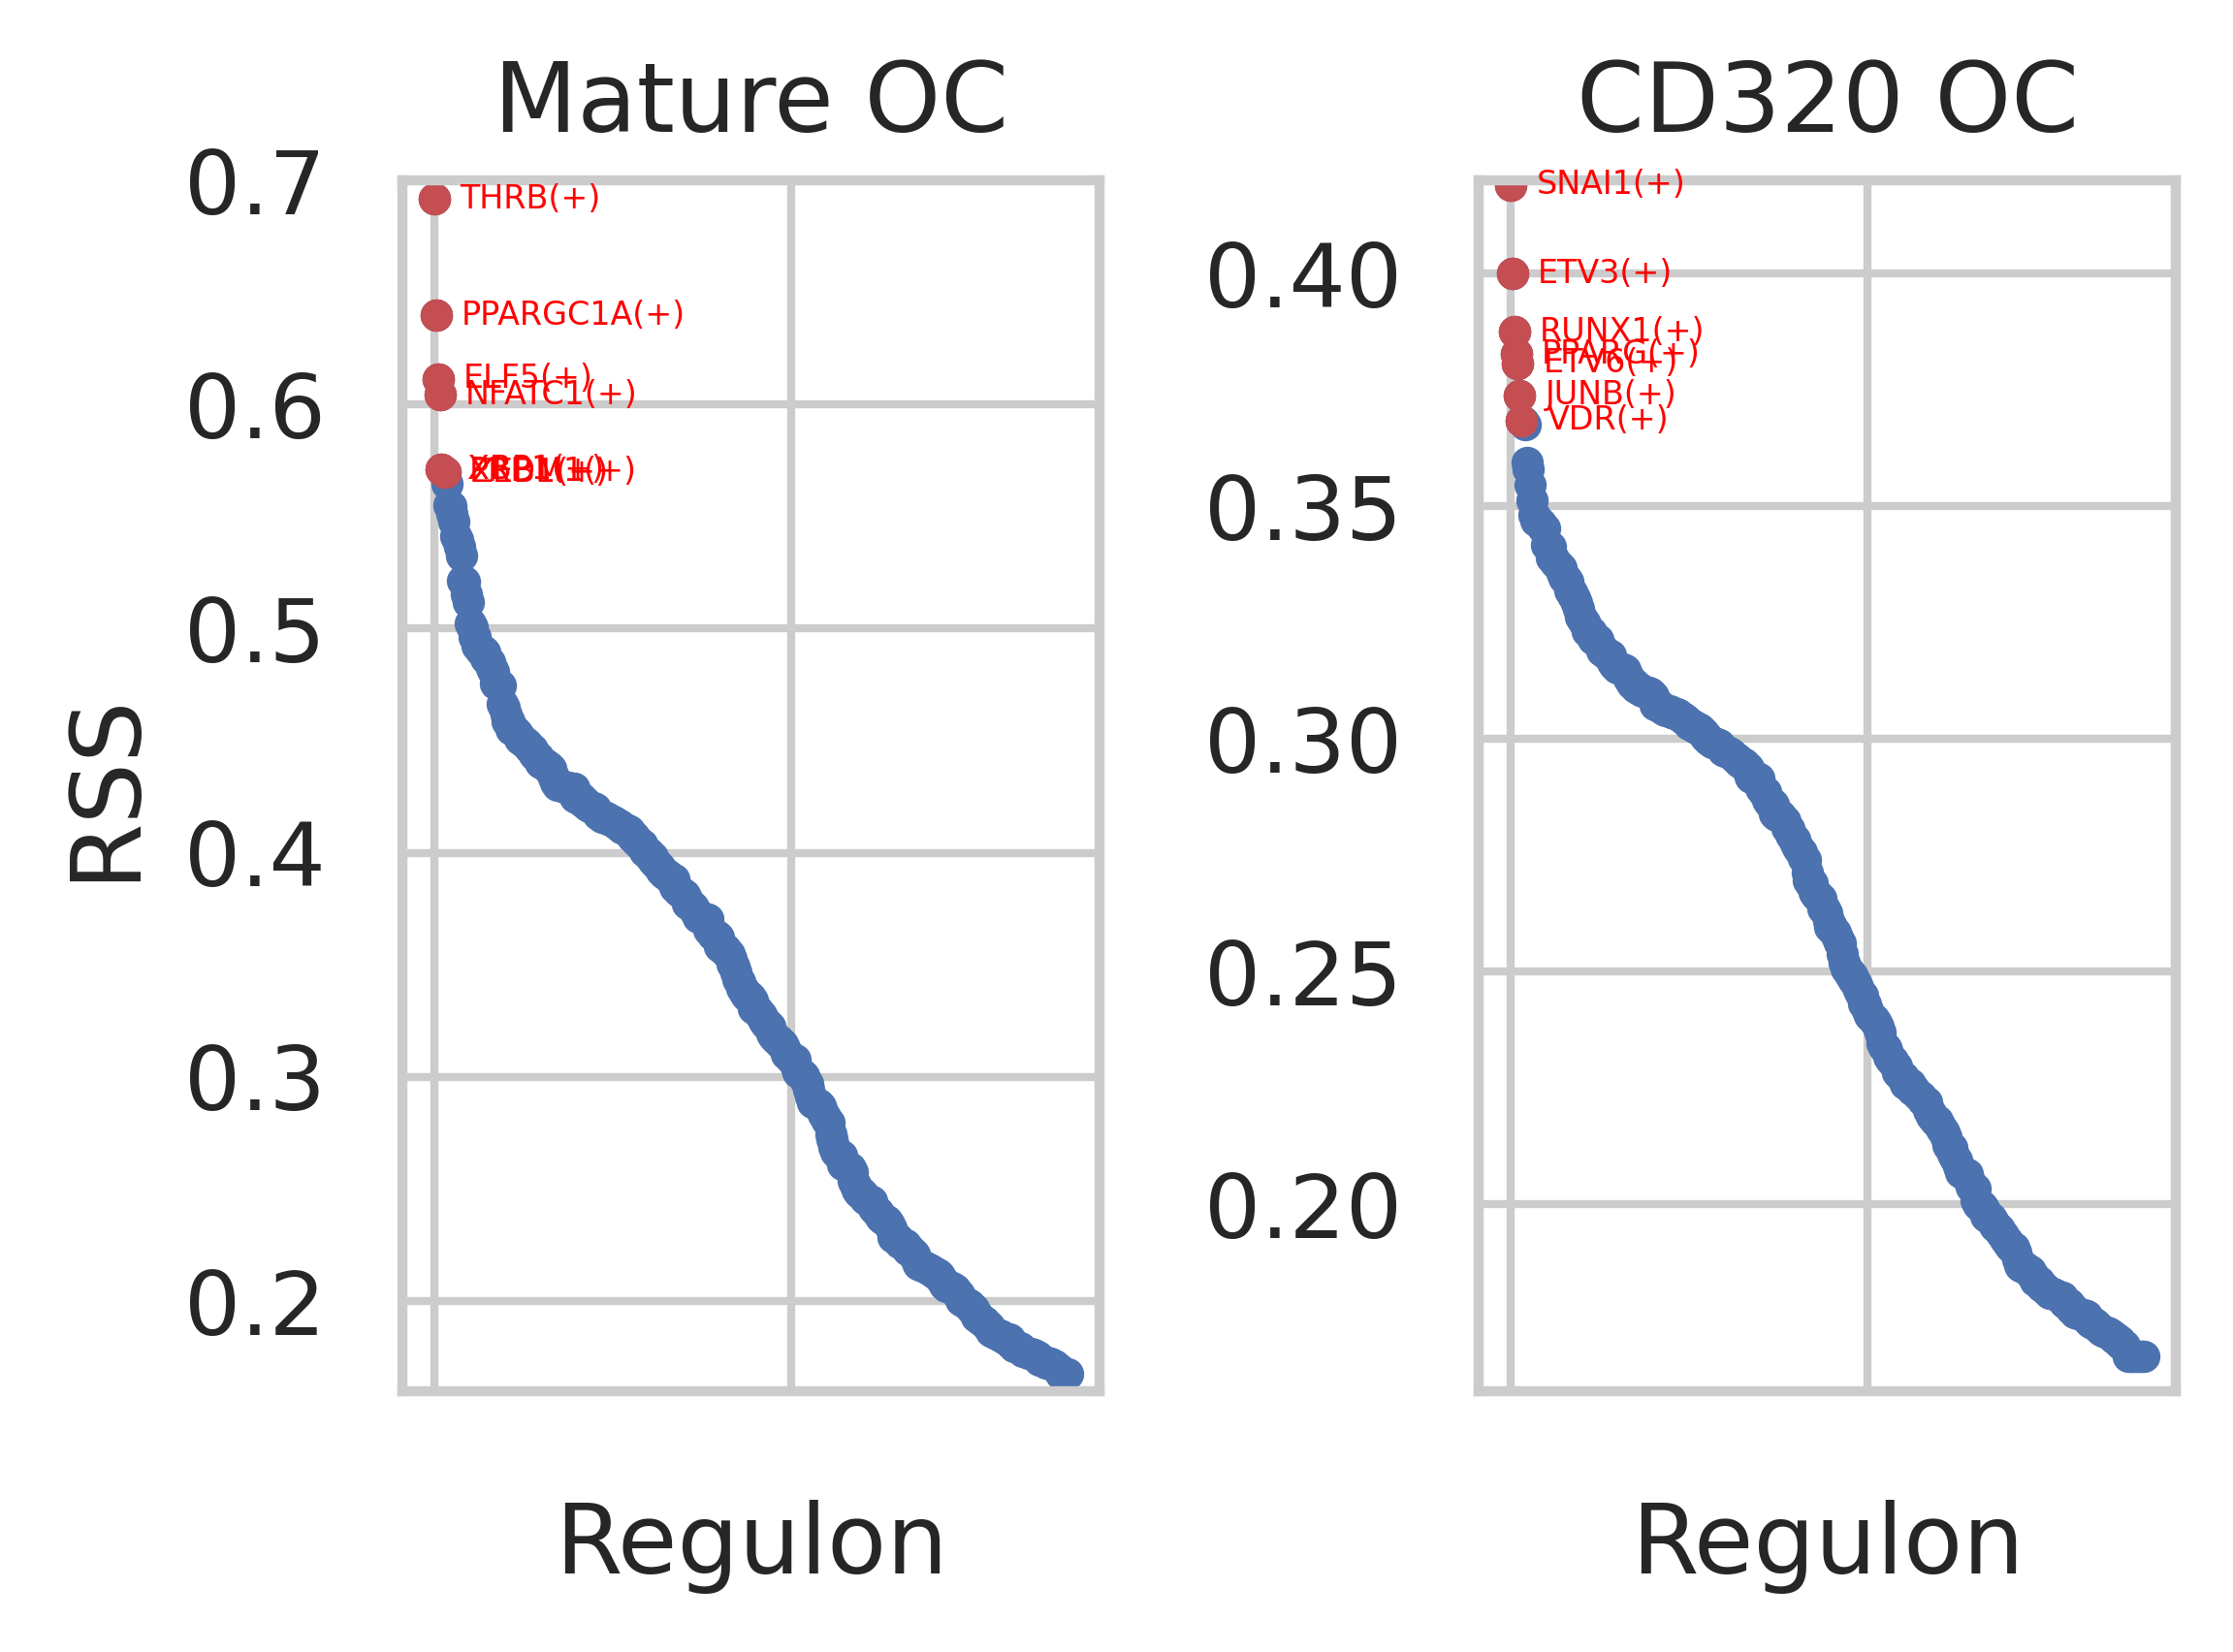

In [18]:
sns.set()
sns.set(style='whitegrid', font_scale=1)
fig, (ax2, ax3) = plt.subplots(1, 2, figsize=(4, 3), dpi=600)
plot_rss(rss, "Mature OC", ax=ax2, top_n = 7)
plot_rss(rss, "CD320 OC", ax=ax3, top_n = 7)
ax3.set_ylabel('')
savesvg('rss.svg', fig)

```r
#read in and prep data
df <- read.csv("../output/scenic/oc_rss.csv", row.names = 1)
colnames(df) <- gsub('\\.\\.\\.',"",colnames(df))
df.all <- t(df) %>% as.data.frame() %>% rownames_to_column()

#plot the data!
labCut = 10
pi <- lapply(2:ncol(df.all), function(x){
    #prep data
    celltype <- colnames(df.all)[x]
    df <- df.all[ ,c("rowname",celltype)] 
    colnames(df) <- c("gene", "clus")
    df <- df %>% arrange(desc(clus))
    df[ ,"gene"] <- factor(df[ ,"gene"], levels = df[ ,"gene"])
    df <- df %>% mutate(colz = ifelse(row_number() < labCut+1, "#FF6961", "lightblue"),
                        labz = ifelse(row_number() < labCut+1, as.character(gene), NA))
    
    #plot the data
    p <- ggplot(df, aes(x = gene, y = clus, label = labz)) +
    geom_point(colour = df$colz, size = 2) + 
    geom_text_repel(
        force = 0.01,
        nudge_x = nrow(df)*0.5,
        direction = "y",
        seed = 42, 
        box.padding = 0.25,
        #hjust = 0,
        #segment.size = 0.2, 
        size = 4, 
        color = df$colz,
        max.iter = 100000000,
        max.overlaps = 10
    ) + 
    labs(
        title = celltype,
        x = "Regulon",
        y = "rss"
    ) + 
    theme_classic() + 
    theme(
        axis.ticks.x = element_blank(),
        axis.text.x = element_blank(),
        panel.border = element_blank(),
        plot.margin = unit(c(10, 10, 10, 10), "pt"),
        panel.background = element_rect(fill = "transparent",colour = NA),
        plot.background = element_rect(fill = "transparent",colour = NA),
        panel.grid.major = element_blank(), 
        panel.grid.minor = element_blank()
    ) + 
    scale_y_continuous(
        breaks = function(y) {
            seq(floor(min(y, digits = 1)), 
            ceiling(max(y, digits = 1)), 
            by = 0.1)
        }
    ) + coord_cartesian(expand = TRUE, clip = "off")

    #return/save plot
    ggsave(paste0("../output/scenic/", gsub(" ", "_", celltype), "_rss.png"), height = 5, width = 3)
    return(p)
})


p <- pi[[3]] + pi[[2]]
ggsave(plot = p, "../output/scenic/oc_rss.png", height = 5, width = 6)

```